# Quantum Bayesian Inference w/Qiskit Simulator and Real QPU Hardware -> Grover Approach on Rejection Sampling

**IMPORTS & BACKENDS(QISKIT)**

In [11]:

import numpy as np
from math import asin, sqrt, pi

import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

#Qiskit Aer backends -> local simulator 
state_backend = Aer.get_backend("statevector_simulator")
qasm_backend  = Aer.get_backend("qasm_simulator")

print("Available Aer backends:")
print(" -", state_backend)
print(" -", qasm_backend)

Available Aer backends:
 - StatevectorSimulator('statevector_simulator')
 - QasmSimulator('qasm_simulator')


**Bayesian Network Encoding to Quantum Gates**

theta_L: 0.06325609887514336
theta_A: 1.5707963267948968
theta_R: {(0, 1): 0.9272952180016122, (0, 0): 1.7721542475852274, (1, 1): 1.7141438957002617, (1, 0): 0.7227342478134157}
BN preparation gate and inverse ready.


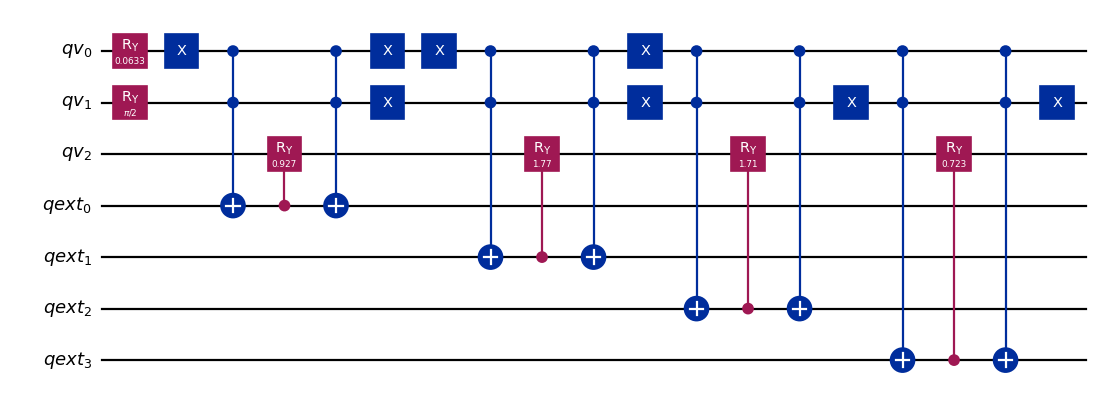

In [12]:
from math import asin, sqrt, pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

#CPTs (L -> R, A -> R)
p_L1 = 0.001          #P(L=1) = rare evidence
p_A1 = 0.5            #P(A=1)
p_R_given = {
    (0, 1): 1/5,
    (0, 0): 3/5,
    (1, 1): 4/7,
    (1, 0): 1/8
}

theta_L = 2 * asin(sqrt(p_L1))
theta_A = 2 * asin(sqrt(p_A1))
theta_R = {key: 2 * asin(sqrt(p)) for key, p in p_R_given.items()}

print("theta_L:", theta_L)
print("theta_A:", theta_A)
print("theta_R:", theta_R)

#BN state preparation circuit
def prepare_bn_state_clean():
    """
    L, A, R için |ψ> prepared states:
      q_v[0] = L
      q_v[1] = A
      q_v[2] = R
    q_ext[0..3] = ancilla
    """
    q_v   = QuantumRegister(3, "qv")
    q_ext = QuantumRegister(4, "qext")
    qc = QuantumCircuit(q_v, q_ext, name="BN_prep_clean")

    # Prior'lar
    qc.ry(theta_L, q_v[0])  # L
    qc.ry(theta_A, q_v[1])  # A

    def mark_pattern(circ, L_val, A_val, ancilla):
        if L_val == 0:
            circ.x(q_v[0])
        if A_val == 0:
            circ.x(q_v[1])
        circ.ccx(q_v[0], q_v[1], ancilla)

    def unmark_pattern(circ, L_val, A_val, ancilla):
        circ.ccx(q_v[0], q_v[1], ancilla)
        if L_val == 0:
            circ.x(q_v[0])
        if A_val == 0:
            circ.x(q_v[1])

    # (L=0, A=1)
    L_val, A_val = 0, 1
    anc = q_ext[0]
    mark_pattern(qc, L_val, A_val, anc)
    qc.cry(theta_R[(L_val, A_val)], anc, q_v[2])
    unmark_pattern(qc, L_val, A_val, anc)

    # (L=0, A=0)
    L_val, A_val = 0, 0
    anc = q_ext[1]
    mark_pattern(qc, L_val, A_val, anc)
    qc.cry(theta_R[(L_val, A_val)], anc, q_v[2])
    unmark_pattern(qc, L_val, A_val, anc)

    # (L=1, A=1)
    L_val, A_val = 1, 1
    anc = q_ext[2]
    mark_pattern(qc, L_val, A_val, anc)
    qc.cry(theta_R[(L_val, A_val)], anc, q_v[2])
    unmark_pattern(qc, L_val, A_val, anc)

    # (L=1, A=0)
    L_val, A_val = 1, 0
    anc = q_ext[3]
    mark_pattern(qc, L_val, A_val, anc)
    qc.cry(theta_R[(L_val, A_val)], anc, q_v[2])
    unmark_pattern(qc, L_val, A_val, anc)

    return qc

#Transform circuit to gate
prep_circ = prepare_bn_state_clean()
prep_gate = prep_circ.to_gate(label="U_BN")
prep_gate_inv = prep_gate.inverse()

print("BN preparation gate and inverse ready.")
prep_circ.draw(output="mpl", scale=0.8)

**Classic BN + CPT -> Sampling**

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

#CPTs
P_L = {1: 0.001, 0: 0.999}
P_A = {1: 1/2, 0: 1/2}

#P(R=1 | L,A)
P_R_given_LA = {
    (0,1): 1/5,
    (0,0): 3/5,
    (1,1): 4/7,
    (1,0): 1/8
}

def sample_from_bn():
    #Sample L
    L = 1 if random.random() < P_L[1] else 0
    
    #Sample A
    A = 1 if random.random() < P_A[1] else 0
    
    #Sample R conditioned on L,A
    p_r = P_R_given_LA[(L, A)]
    R = 1 if random.random() < p_r else 0
    
    return (L, A, R)

**Rejection Sampling**

In [14]:
def rejection_sampling(evidence_var="R", evidence_val=1, target_count=100):
    """
    Runs rejection sampling until we collect target_count accepted samples.
    Returns: total_samples_generated, accepted_samples
    """
    accepted = []
    total = 0
    
    while len(accepted) < target_count:
        s = sample_from_bn()
        total += 1
        
        L, A, R = s
        
        #Check evidence
        if evidence_var == "R" and R == evidence_val:
            accepted.append(s)
        elif evidence_var == "L" and L == evidence_val:
            accepted.append(s)
        elif evidence_var == "A" and A == evidence_val:
            accepted.append(s)
    
    return total, accepted

**An Experiment for Different Evidence Probabilities**

In [15]:
evidences = [
    ("R", 1),  #most rare evidence
    ("R", 0),
    ("A", 1),
    ("A", 0),
    ("L", 1),
    ("L", 0)
]

results = {}

for var, val in evidences:
    total_needed, _ = rejection_sampling(var, val, target_count=100)
    results[(var,val)] = total_needed

results

{('R', 1): 266,
 ('R', 0): 174,
 ('A', 1): 204,
 ('A', 0): 203,
 ('L', 1): 103500,
 ('L', 0): 100}

**Graph Results for Classic Rejection Sampling**

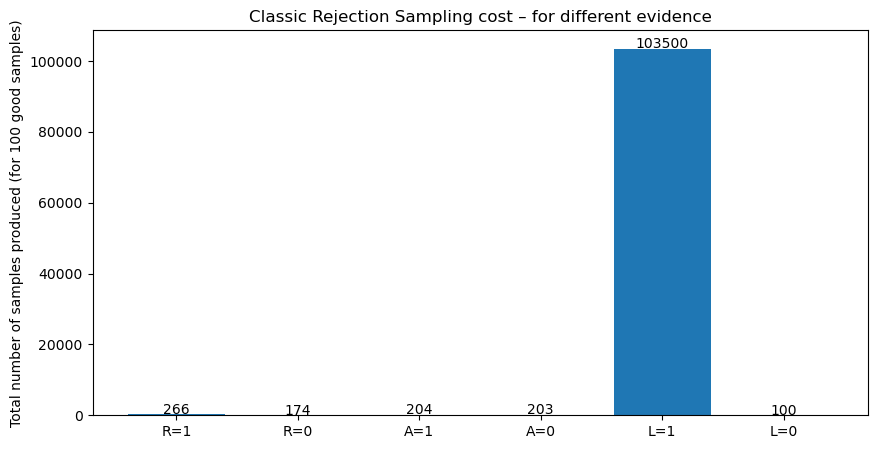

In [16]:
labels = [f"{v}={x}" for (v,x) in results.keys()]
values = list(results.values())

plt.figure(figsize=(10,5))
bars = plt.bar(labels, values)
plt.ylabel("Total number of samples produced (for 100 good samples)")
plt.title("Classic Rejection Sampling cost – for different evidence")

for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + 50, f"{y}", ha="center")

plt.show()

**Lets Start Quantum Inference**

- Oracle and Diffusion Operators for Amplitude Amplification

In [17]:
#Oracle: if L=1 -> coherence flip (Z)
def oracle_L_eq_1_gate():
    q = QuantumRegister(7, "q")
    qc = QuantumCircuit(q, name="O_L1")
    qc.z(q[0])     # L qubit'i q[0]
    return qc.to_gate(label="O_L1")

oracle_gate = oracle_L_eq_1_gate()
print("Oracle gate ready:", oracle_gate)

#|0...0><0...0| -> Reflection Identity
def build_reflect_zero_gate(num_qubits=7):
    q = QuantumRegister(num_qubits, "rz")
    qc = QuantumCircuit(q, name="R0")

    qc.x(q) #|0..0> -> |1..1>

    controls = list(q)[:-1]
    target   = list(q)[-1]

    qc.h(target)
    mcx = MCXGate(num_ctrl_qubits=len(controls))
    qc.append(mcx, controls + [target])
    qc.h(target)

    qc.x(q) #|1..1> -> |0..0>

    return qc.to_gate(label="R0")

reflect_zero_gate = build_reflect_zero_gate()
print("Reflection-zero gate ready:", reflect_zero_gate)

Oracle gate ready: Instruction(name='O_L1', num_qubits=7, num_clbits=0, params=[])
Reflection-zero gate ready: Instruction(name='R0', num_qubits=7, num_clbits=0, params=[])


**Construction of the Reflection about Zero Operator (R0)**

In [18]:
from qiskit.circuit.library import MCXGate
def build_reflect_zero_gate(num_qubits=7): 
    """
    |0...0> reflection on the state: 2|0><0| - I
    Steps:
      X...X
      H(target)
      MCX(controls -> target)
      H(target)
      X...X
    """
    q = QuantumRegister(num_qubits, "q")
    qc = QuantumCircuit(q, name="R0")

    #X on all qubits
    qc.x(q)

    # Multi-controlled for Z: H - MCX - H
    target = q[num_qubits - 1]
    controls = list(q)[:-1]

    qc.h(target)
    mcx = MCXGate(num_ctrl_qubits=len(controls))
    qc.append(mcx, controls + [target])
    qc.h(target)

    #Back to original
    qc.x(q)

    return qc.to_gate(label="R0")

reflect_zero_gate = build_reflect_zero_gate()
print(reflect_zero_gate)

Instruction(name='R0', num_qubits=7, num_clbits=0, params=[])


**Reflection about the Prepared Bayesian State (Rψ = U† R₀ U)**

In [19]:
def build_reflect_psi_gate():
    q = QuantumRegister(7, "q")
    qc = QuantumCircuit(q, name="Rpsi")

    #U_BN†
    qc.append(prep_gate_inv, q)

    #R0
    qc.append(reflect_zero_gate, q)

    #U_BN
    qc.append(prep_gate, q)

    return qc.to_gate(label="Rψ")

reflect_psi_gate = build_reflect_psi_gate()
print("Reflection-psi gate ready:", reflect_psi_gate)

Reflection-psi gate ready: Instruction(name='Rpsi', num_qubits=7, num_clbits=0, params=[])


**Grover Iteration Count Estimation**

In [20]:
# Evidence: L = 1+
p_e = p_L1

k_approx = int(round(pi/(4*sqrt(p_e)) - 0.5))
if k_approx < 1:
    k_approx = 1

print("P(evidence = L=1) =", p_e)
print("Grover iteration number (k) ≈", k_approx)

P(evidence = L=1) = 0.001
Grover iteration number (k) ≈ 24


**Amplitude Amplification Circuit Construction and Measurement**
- Apply 24 grover iterations

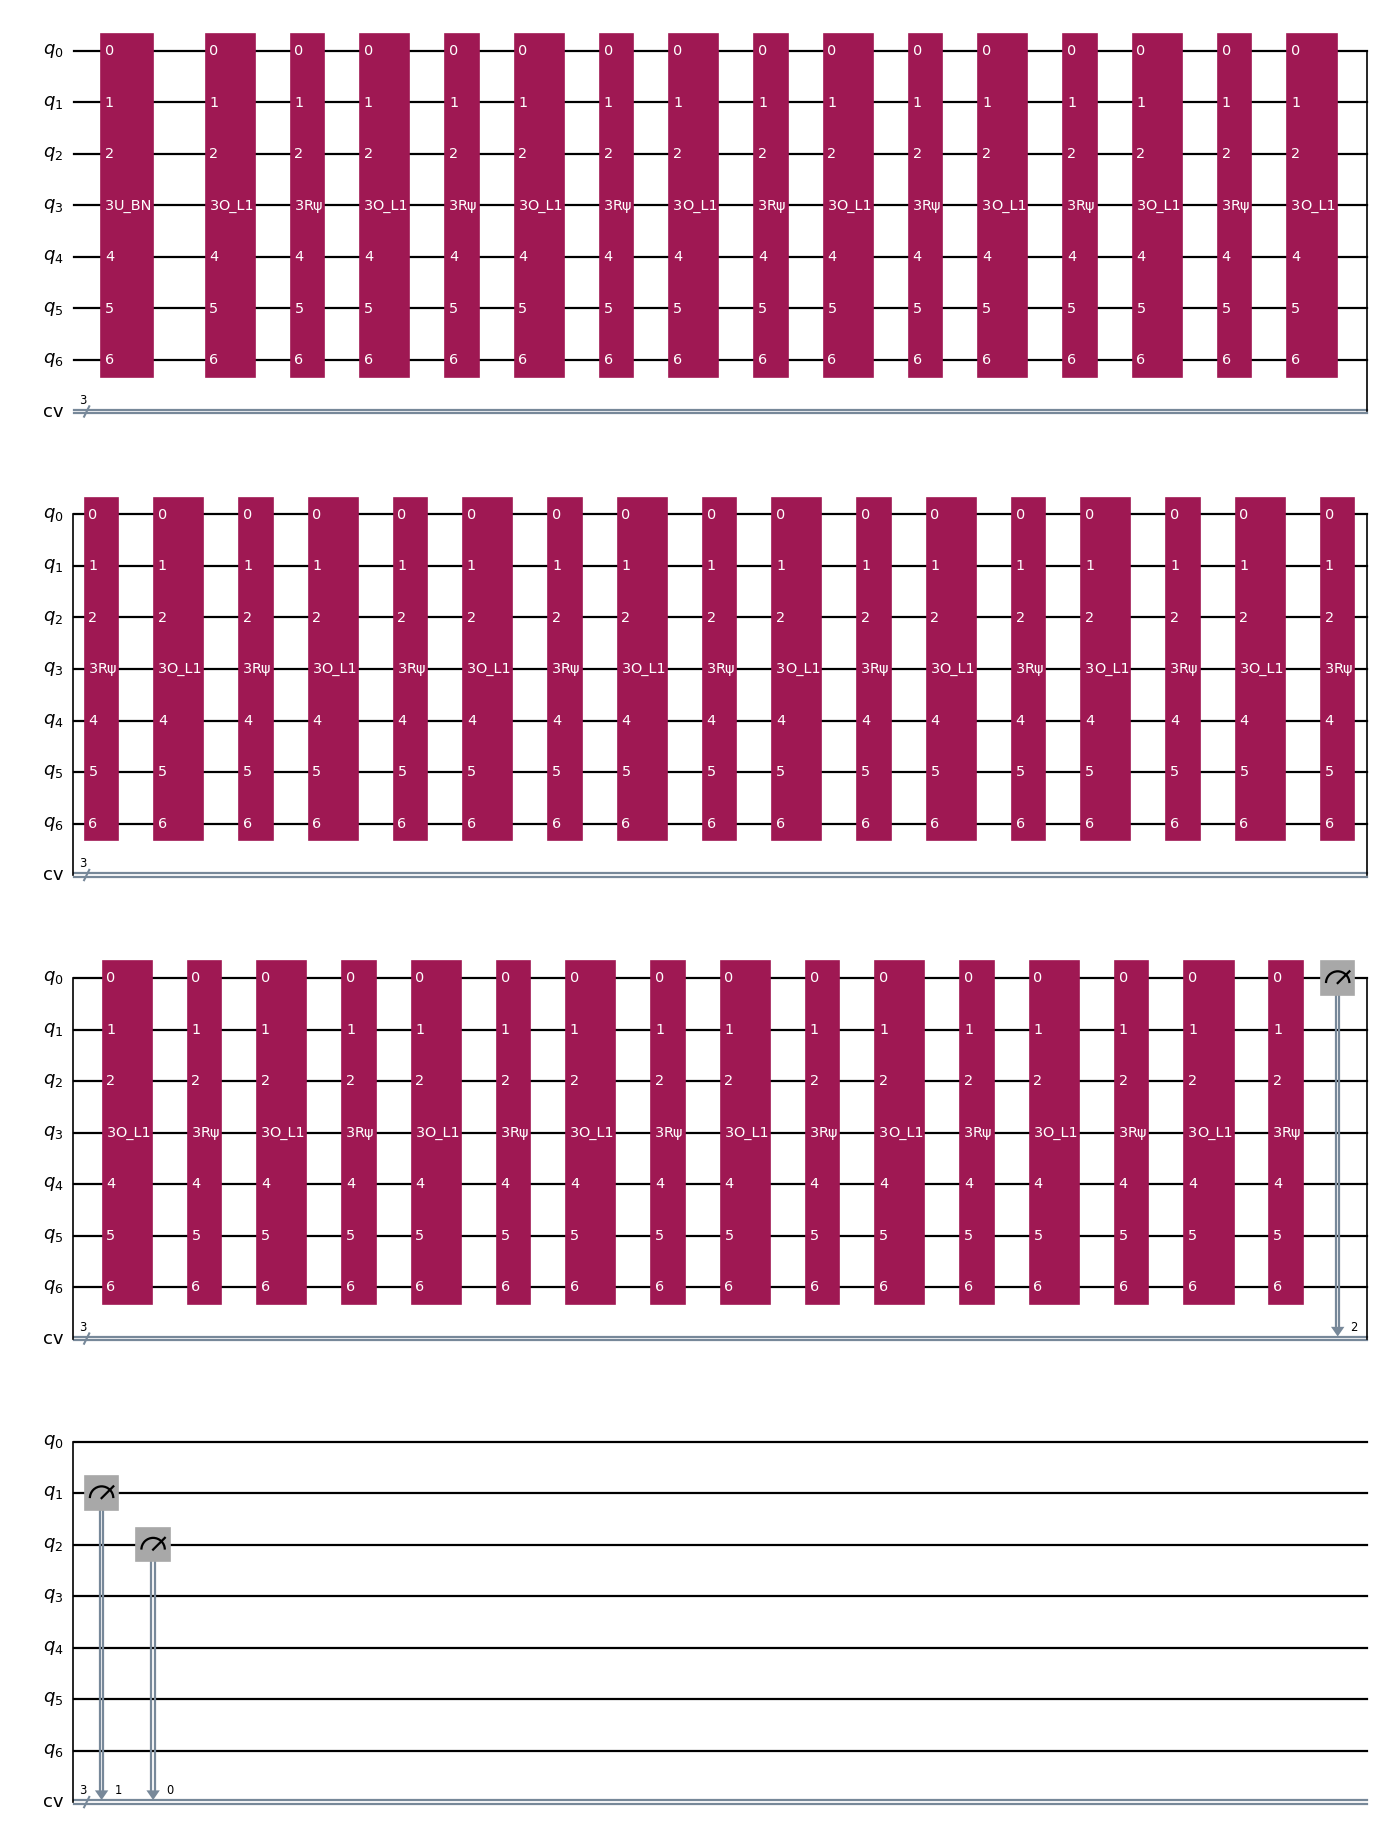

In [21]:
from qiskit_aer import Aer

qasm_backend = Aer.get_backend("qasm_simulator")

def build_amplitude_amplification_circuit(k_iters):
    q = QuantumRegister(7, "q")
    c = ClassicalRegister(3, "cv")
    qc = QuantumCircuit(q, c, name="Grover_L1")

    #1)Initial BN state preparation
    qc.append(prep_gate, q)

    #2) #k: Oracle + Reflection
    for _ in range(k_iters):
        qc.append(oracle_gate, q)
        qc.append(reflect_psi_gate, q)

    #3) Only L, A, R measurements:
    #L = q[0] -> cv[2]
    #A = q[1] -> cv[1]
    #R = q[2] -> cv[0]
    qc.measure(q[0], c[2])
    qc.measure(q[1], c[1])
    qc.measure(q[2], c[0])

    return qc

qc_amp = build_amplitude_amplification_circuit(k_approx)
qc_amp.draw(output="mpl", scale=0.8)

**Run Simulator**

After Grover counts (LAR):
{'010': 1, '000': 1, '100': 2167, '110': 1095, '001': 3, '101': 303, '111': 1430}


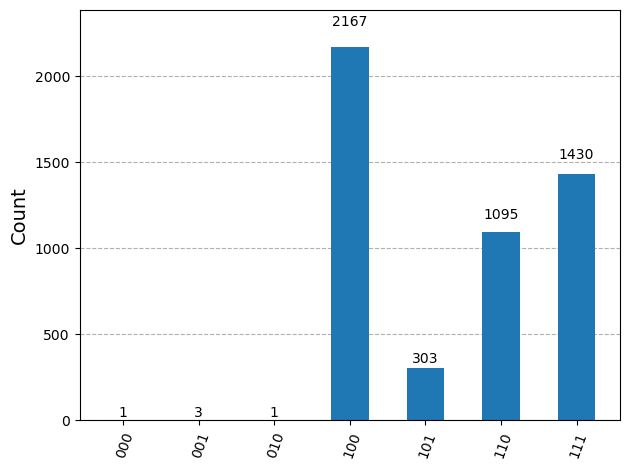

In [22]:
#Decompose all gates for Aer's sake
qc_amp_decomp = qc_amp.decompose(reps=5)

#Vizualize decomposed circuit
qc_amp_decomp.draw(output="mpl", scale=0.7)

#Run Simulator with shots 5000
result_amp = qasm_backend.run(qc_amp_decomp, shots=5000).result()
counts_amp = result_amp.get_counts()

print("After Grover counts (LAR):")
print(counts_amp)

plot_histogram(counts_amp)

**Making quantum results compatible with the classical format**

In [23]:
quantum_results = {}

#Total L=1 number
L1 = sum(c for bits, c in counts_amp.items() if bits[0] == "1")
L0 = sum(c for bits, c in counts_amp.items() if bits[0] == "0")

#Total A=1 number
A1 = sum(c for bits, c in counts_amp.items() if bits[1] == "1")
A0 = sum(c for bits, c in counts_amp.items() if bits[1] == "0")

#Total R=1 number
R1 = sum(c for bits, c in counts_amp.items() if bits[2] == "1")
R0 = sum(c for bits, c in counts_amp.items() if bits[2] == "0")

#Same regular format dictionary as classic results
quantum_results = {
    ('R', 1): R1,
    ('R', 0): R0,
    ('A', 1): A1,
    ('A', 0): A0,
    ('L', 1): L1,
    ('L', 0): L0,
}

print("Quantum results (same format as classic results):")
print(quantum_results)

Quantum results (same format as classic results):
{('R', 1): 1736, ('R', 0): 3264, ('A', 1): 2526, ('A', 0): 2474, ('L', 1): 4995, ('L', 0): 5}


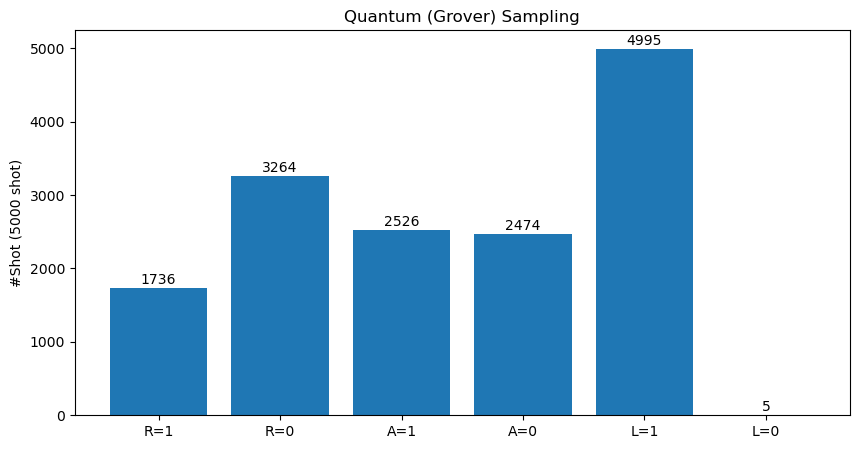

In [24]:
labels_q = [f"{v}={x}" for (v,x) in quantum_results.keys()]
values_q = list(quantum_results.values())

plt.figure(figsize=(10,5))
bars_q = plt.bar(labels_q, values_q)
plt.ylabel("#Shot (5000 shot)")
plt.title("Quantum (Grover) Sampling")

for b in bars_q:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + max(values_q)*0.01, f"{y}", ha="center")

plt.show()

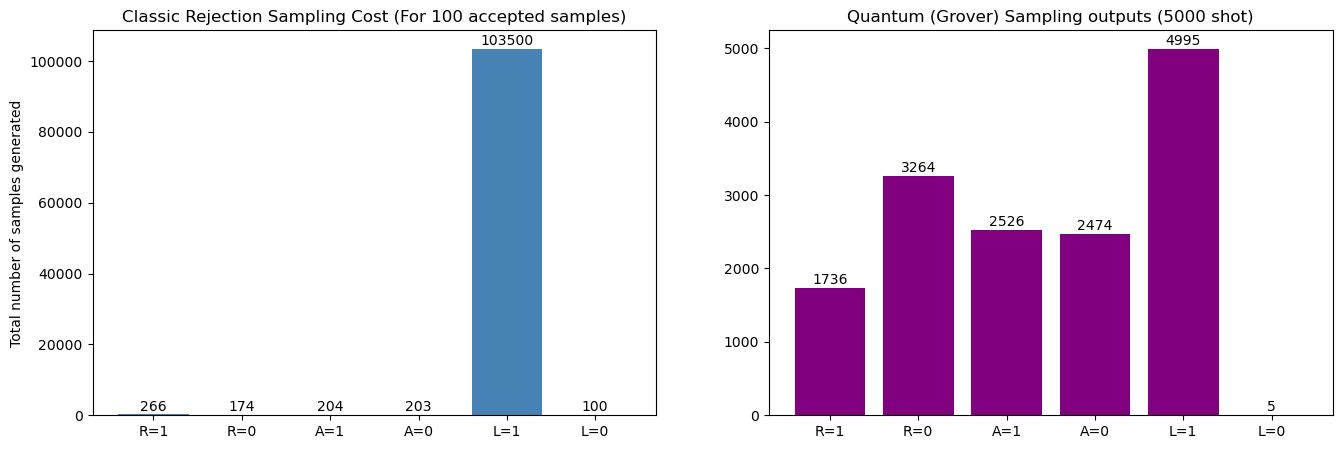

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

#Classic
labels_c = [f"{v}={x}" for (v,x) in results.keys()]
values_c = list(results.values())

ax[0].bar(labels_c, values_c, color="steelblue")
ax[0].set_title("Classic Rejection Sampling Cost (For 100 accepted samples)")
ax[0].set_ylabel("Total number of samples generated")
for i, v in enumerate(values_c):
    ax[0].text(i, v + max(values_c)*0.01, f"{v}", ha="center")

#Quantum
labels_q = [f"{v}={x}" for (v,x) in quantum_results.keys()]
values_q = list(quantum_results.values())

ax[1].bar(labels_q, values_q, color="purple")
ax[1].set_title("Quantum (Grover) Sampling outputs (5000 shot)")
for i, v in enumerate(values_q):
    ax[1].text(i, v + max(values_q)*0.01, f"{v}", ha="center")

plt.show()

**REAL HARDWARE**

- My IBM Cloud Account

In [30]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.saved_accounts()

{'default-ibm-quantum-platform': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'SJC_vj5Nq--dKGkr1XHcHqWAujonUibha-5x5V5tvGgZ',
  'verify': True,
  'private_endpoint': False}}

- Lets See the available device

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum_platform")

backends = service.backends()
for b in backends:
    print(b.name, "| qubits:", b.num_qubits, "| simulator:", b.simulator)

qiskit_runtime_service.__init__:WARNING:2025-12-15 17:27:42,831: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-15 17:27:42,832: Loading instance: open-instance, plan: open


ibm_fez | qubits: 156 | simulator: False
ibm_torino | qubits: 133 | simulator: False
ibm_marrakesh | qubits: 156 | simulator: False


- Torino looks good, check queue for it

In [32]:
service.backend("ibm_torino").status()

qiskit_runtime_service.backends:WARNING:2025-12-15 17:28:26,334: Using instance: open-instance, plan: open


- Here we go! (Apply on QPU)

In [50]:
from qiskit import QuantumCircuit
import numpy as np

#Original circuit: qc_amp_decomp
qc_hw = qc_amp_decomp.copy()

# CACHE BREAKER — same qubit double with X gate -> effect 0 (I gate)
dummy_qubit = 0   #Choose any qubit index
qc_hw.x(dummy_qubit)
qc_hw.x(dummy_qubit)

#Seed for transpiler
seed = np.random.randint(1e9)
print("Using transpiler seed:", seed)

qc_hw = transpile(qc_hw, backend, seed_transpiler=seed)

Using transpiler seed: 830393069


Hardware counts:
{'011': 939, '010': 831, '001': 984, '110': 308, '000': 867, '100': 356, '111': 327, '101': 388}


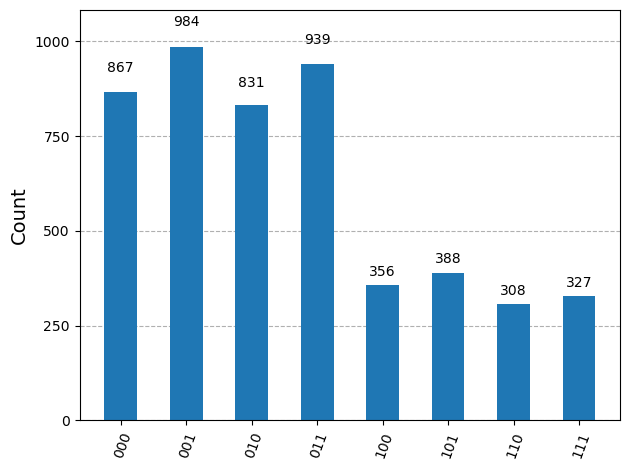

In [51]:
from collections import Counter
from qiskit.visualization import plot_histogram

pub = result[0]
bit_array = pub.data.cv   #BitArray

# Runtime V2 API:
bitstrings = bit_array.get_bitstrings()
counts = bit_array.get_counts()

print("Hardware counts:")
print(counts)

plot_histogram(counts)